<font size=7>Data Clustering for China stock data</font>

导入依赖库：

In [32]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from concurrent import futures
import numpy as np
import pandas_datareader.data as web
from scipy.stats import gaussian_kde
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster, set_link_color_palette
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans


data_dir = "./data/stock_data_for_clustering"
os.makedirs(data_dir, exist_ok=True)

下载数据：

In [33]:
# def download_stock(stock):
#     try:
#         print(stock)
#         stock_df = web.DataReader(stock,'yahoo', start_time, end_time)
#         stock_df['Name'] = stock
#         output_name = f"{data_dir}/{stock}.csv"
#         stock_df.to_csv(output_name)
#     except:
#         bad_names.append(stock)
#         print('bad: %s' % (stock))


# """ set the download window """
# start_time = dt.datetime(2021, 12, 1)
# end_time = dt.datetime(2022, 3, 1)

# bad_names =[] #to keep track of failed queries
# #set the maximum thread number
# max_workers = 20
# now = dt.datetime.now()

# workers = min(max_workers, len(sp500_tickers)) #in case a smaller number of stocks than threads was passed in
# with futures.ThreadPoolExecutor(workers) as executor:
#     res = executor.map(download_stock, sp500_tickers)

# """ Save failed queries to a text file to retry """
# if len(bad_names) > 0:
#     with open(f'{data_dir}/failed_queries.txt','w') as outfile:
#         for name in bad_names:
#             outfile.write(name+'\n')
            
# finish_time = dt.datetime.now()
# duration = finish_time - now
# minutes, seconds = divmod(duration.seconds, 60)
# print(f'The threaded script took {minutes} minutes and {seconds} seconds to run.')
# print(f"{len(bad_names)} stocks failed: ", bad_names)

In [34]:
import tushare as ts


# ts.set_token('ca95340dcbebdf14a140f89c2d0aa3aee0c878f20c6dd3bd0237dc12')
# pro = ts.pro_api()

# #查询当前所有正常上市交易的股票列表
# stock_codes = pro.query('stock_basic',  list_status='L',fields='ts_code')
# print('获取股票个数：{0}'.format(len(stock_codes)))

# stock_list = []
# for stock in stock_codes.ts_code:
#     stock_list.append(stock)
#     # 获取每只股票的行情信息
#     df = ts.pro_bar(ts_code=stock, ma=[5, 10, 20 ], factors=['tor', 'vr'], adj='qfq', start_date='20220101', end_date='20220220')
#     output_name = f"{data_dir}/{code}.csv"
#     df.to_csv(output_name)
#     # 可以根据自己要求存储，这里是插入数据库

# # 下载股票数据
# code_list = ['600000','600004','600006','600007','600008','600009','600010','600015','600016','600017','600018','600019','600020','600021','600022','600023','600025','600026','600027','600028','600029','600030','600031','600032','600033','600035','600036']
# for code in code_list:
#     df = ts.get_k_data(code=code, start='2019-10-01', end='2022-10-01')
#     output_name = f"{data_dir}/{code}.csv"
#     df.to_csv(output_name)


数据预处理：

In [35]:
historical_stock_data_files = glob.glob(f"./{data_dir}/*.csv")

reference_day = "2019-10-08"
start_day = "2019-12-02"
midterm_day = "2020-10-09"
end_day = "2022-07-01"
price_change_list = []
tickers_to_ignore = []

for files in historical_stock_data_files:
    df = pd.read_csv(files, index_col=["date"])
    ticker = os.path.splitext(os.path.basename(files))[0]
    try:
        price_close = df[reference_day: end_day][["close"]]
        price_change = (price_close / price_close.loc[reference_day, "close"] - 1) * 100
        price_change = price_change.iloc[1: ,:]
        price_change = price_change.rename(columns={"close": ticker})
        price_change_list.append(price_change)
    except KeyError as e:
        # some stocks started trading after 2021-12-31
        print(ticker)
        tickers_to_ignore.append(ticker)
    
df = pd.concat(price_change_list, axis=1)
print(df.shape)
df.head()

600032
(664, 26)


,600000,600004,600006,600007,600008,600009,600010,600015,600016,600017,...,600025,600026,600027,600028,600029,600030,600031,600033,600035,600036
date,,,,,,,,,,,,,,,,,,,,,
2019-10-09,0.831793,0.307382,0.460723,0.603622,0.519570,0.454604,0.68918,1.221001,1.135503,0.350877,...,3.455609,0.000000,0.948167,0.241546,-0.612557,-0.428432,-1.222307,0.724638,0.668896,1.143493
2019-10-10,0.554529,2.195582,1.612532,3.353454,1.350883,3.506949,0.68918,1.373626,0.567752,1.052632,...,6.379585,7.745267,2.212389,0.000000,4.134763,0.253165,-0.993125,1.449275,2.341137,0.927156
2019-10-11,5.083179,2.371229,1.842893,10.395708,2.667129,3.221198,0.68918,2.594628,1.703255,1.754386,...,6.113769,18.932874,2.528445,1.932367,5.666156,2.590068,1.527884,1.811594,3.010033,4.573972
2019-10-14,9.611830,-1.668643,2.994702,9.792086,2.667129,1.883361,1.37836,5.036630,3.595761,2.456140,...,4.518873,22.375215,3.160556,1.932367,6.278714,3.227848,1.680672,3.260870,4.013378,6.242853
2019-10-15,10.998152,-0.263470,1.842893,9.993293,1.870454,0.649435,0.00000,5.036630,3.406510,2.456140,...,4.253057,16.006885,3.476612,0.966184,5.972435,1.528724,3.514133,2.173913,2.341137,5.655654


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 664 entries, 2019-10-09 to 2022-07-01
Data columns (total 26 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   600000  664 non-null    float64
 1   600004  664 non-null    float64
 2   600006  660 non-null    float64
 3   600007  664 non-null    float64
 4   600008  658 non-null    float64
 5   600009  653 non-null    float64
 6   600010  664 non-null    float64
 7   600015  664 non-null    float64
 8   600016  664 non-null    float64
 9   600017  664 non-null    float64
 10  600018  664 non-null    float64
 11  600019  664 non-null    float64
 12  600020  664 non-null    float64
 13  600021  664 non-null    float64
 14  600022  664 non-null    float64
 15  600023  664 non-null    float64
 16  600025  664 non-null    float64
 17  600026  664 non-null    float64
 18  600027  663 non-null    float64
 19  600028  664 non-null    float64
 20  600029  664 non-null    float64
 21  600030  657 non-null    floa

缺失数据处理：

In [37]:
def check_missing_data(df):
    # check for any missing data in the df (display in descending order)
    return df.isnull().sum().sort_values(ascending=False)

check_missing_data(df)

nan_cols = df.columns[df.isnull().any()].tolist()

In [38]:
# filling a missing value with
# previous ones 
# df.fillna(method ='pad')
# df.replace(to_replace = np.nan, value = 0)
df = df.dropna(axis=0)

for col in nan_cols:
    df[col] = df[col].replace(np.NaN, df[col].mean())

In [39]:
data_1 = df.loc[[end_day], :]
display(data_1.head())
data_2 = df.loc[[start_day, midterm_day, end_day], :]
display(data_2.head())
data_3 = df
display(data_3.head())

,600000,600004,600006,600007,600008,600009,600010,600015,600016,600017,...,600025,600026,600027,600028,600029,600030,600031,600033,600035,600036
date,,,,,,,,,,,,,,,,,,,,,
2022-07-01,-26.155268,-37.162429,74.383783,1.676727,1.489435,-29.66619,71.605789,-20.787546,-29.788039,5.964912,...,90.05848,70.051635,24.525917,-1.449275,6.891271,3.894839,51.566081,0.362319,9.0301,27.885774


,600000,600004,600006,600007,600008,600009,600010,600015,600016,600017,...,600025,600026,600027,600028,600029,600030,600031,600033,600035,600036
date,,,,,,,,,,,,,,,,,,,,,
2019-12-02,-0.277264,-27.005665,-0.921447,0.737760,-2.701767,-2.441876,-13.094418,-0.152625,1.703255,-4.561404,...,0.000000,-5.851979,8.217446,-1.207729,1.378254,-2.765336,2.826585,-1.449275,-2.341137,4.017678
2020-10-09,-17.375231,-40.288939,12.347385,-17.505030,-4.399030,-9.832446,-21.364576,-15.735653,-7.759273,-4.385965,...,3.455609,23.407917,5.562579,-21.256039,-10.107198,37.263875,87.448434,-11.231884,-9.364548,7.942640
2022-07-01,-26.155268,-37.162429,74.383783,1.676727,1.489435,-29.666190,71.605789,-20.787546,-29.788039,5.964912,...,90.058480,70.051635,24.525917,-1.449275,6.891271,3.894839,51.566081,0.362319,9.030100,27.885774


,600000,600004,600006,600007,600008,600009,600010,600015,600016,600017,...,600025,600026,600027,600028,600029,600030,600031,600033,600035,600036
date,,,,,,,,,,,,,,,,,,,,,
2019-10-09,0.831793,0.307382,0.460723,0.603622,0.519570,0.454604,0.68918,1.221001,1.135503,0.350877,...,3.455609,0.000000,0.948167,0.241546,-0.612557,-0.428432,-1.222307,0.724638,0.668896,1.143493
2019-10-10,0.554529,2.195582,1.612532,3.353454,1.350883,3.506949,0.68918,1.373626,0.567752,1.052632,...,6.379585,7.745267,2.212389,0.000000,4.134763,0.253165,-0.993125,1.449275,2.341137,0.927156
2019-10-11,5.083179,2.371229,1.842893,10.395708,2.667129,3.221198,0.68918,2.594628,1.703255,1.754386,...,6.113769,18.932874,2.528445,1.932367,5.666156,2.590068,1.527884,1.811594,3.010033,4.573972
2019-10-14,9.611830,-1.668643,2.994702,9.792086,2.667129,1.883361,1.37836,5.036630,3.595761,2.456140,...,4.518873,22.375215,3.160556,1.932367,6.278714,3.227848,1.680672,3.260870,4.013378,6.242853
2019-10-15,10.998152,-0.263470,1.842893,9.993293,1.870454,0.649435,0.00000,5.036630,3.406510,2.456140,...,4.253057,16.006885,3.476612,0.966184,5.972435,1.528724,3.514133,2.173913,2.341137,5.655654


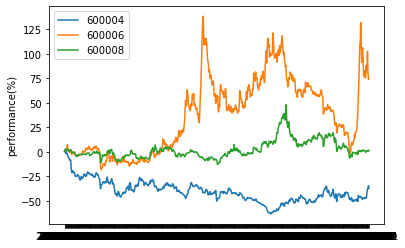

In [40]:
examples = ["600004", "600006", "600008"]
for x in examples:
    plt.plot(data_3[x], label=x)
#plt.xticks(rotation=90)
plt.ylabel("performance(%)")
plt.legend(loc="best")
plt.show()

多维聚类：

d:\Program Files\Anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
d:\Program Files\Anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(26, 2)


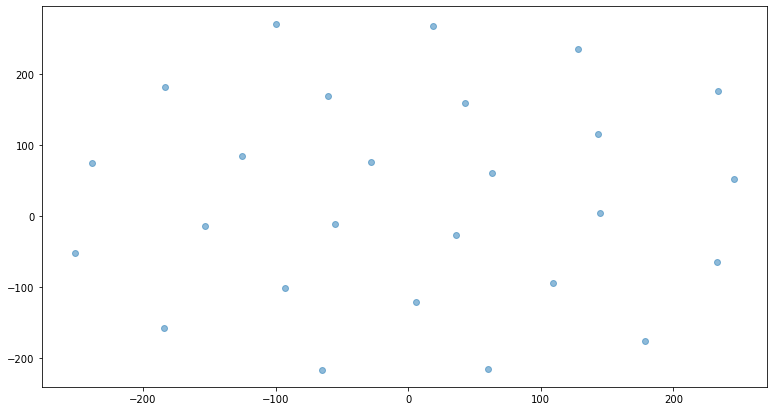

In [41]:
tsne = TSNE(n_components=2, random_state=41)
X_reduced = tsne.fit_transform(data_3.T)
print(X_reduced.shape)
plt.figure(figsize=(13, 7))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], alpha=0.5)
plt.show()